## Importing Libraries

In [ ]:
# For data preprocessing
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# To build visualizations
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns

# For Saving the Model
import pickle

## Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
holidays_events = pd.read_csv('/content/drive/MyDrive/favorita-grocery-sales-forecasting/holidays_events.csv')
oil = pd.read_csv('/content/drive/MyDrive/favorita-grocery-sales-forecasting/oil.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/favorita-grocery-sales-forecasting/sample_submission.csv')
stores = pd.read_csv('/content/drive/MyDrive/favorita-grocery-sales-forecasting/stores.csv')
test = pd.read_csv('/content/drive/MyDrive/favorita-grocery-sales-forecasting/test.csv')
transactions = pd.read_csv('/content/drive/MyDrive/favorita-grocery-sales-forecasting/transactions.csv')
sales = pd.read_csv('/content/drive/MyDrive/favorita-grocery-sales-forecasting/train.csv')

In [ ]:
print("Store columns:", stores.columns.tolist())
print("Sales columns:", sales.columns.tolist())

Store columns: ['store_nbr', 'city', 'state', 'type', 'cluster']
Sales columns: ['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion']


In [ ]:
train = sales.merge(stores, how="left", on='store_nbr')
train = train.merge(oil, how="left", on='date')
train = train.merge(transactions, how="left", on=['date','store_nbr'])
train = train.merge(holidays_events,on='date',how='left')
train = train.rename(columns={'type_x' : 'store_type','type_y':'holiday_type'})

In [ ]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,transactions,holiday_type,locale,locale_name,description,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday,National,Ecuador,Primer dia del ano,False


In [ ]:
train.isnull().sum()

,0
id,0
date,0
store_nbr,0
family,0
sales,0
onpromotion,0
city,0
state,0
store_type,0
cluster,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 17 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            int64  
 1   date          object 
 2   store_nbr     int64  
 3   family        object 
 4   sales         float64
 5   onpromotion   int64  
 6   city          object 
 7   state         object 
 8   store_type    object 
 9   cluster       int64  
 10  dcoilwtico    float64
 11  transactions  float64
 12  holiday_type  object 
 13  locale        object 
 14  locale_name   object 
 15  description   object 
 16  transferred   object 
dtypes: float64(3), int64(4), object(10)
memory usage: 396.1+ MB


In [ ]:
duplicate_count_train = train.duplicated().sum()
print(f"Number of duplicated records in Train: {duplicate_count_train}")

Number of duplicated records in Train: 0


In [ ]:
train['date'] = pd.to_datetime(train['date'])
train.sort_values('date', inplace=True)

## Handling Missing Values

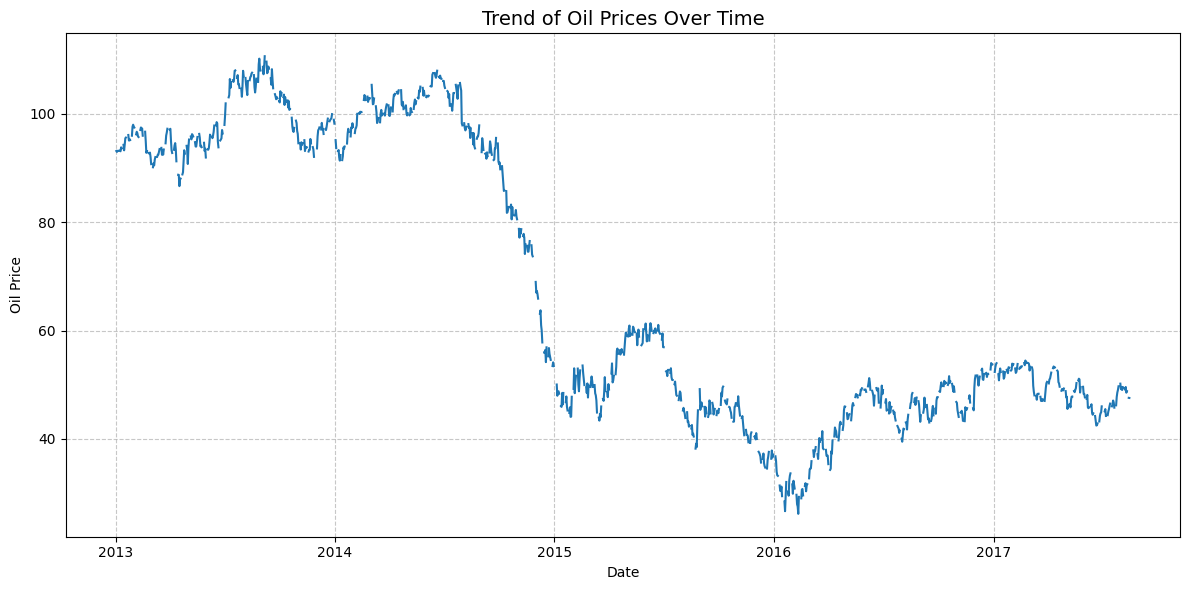

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(train['date'], train['dcoilwtico'])

ax.set_title('Trend of Oil Prices Over Time', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Oil Price')

ax.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
train['dcoilwtico'] = train['dcoilwtico'].fillna(method='backfill')

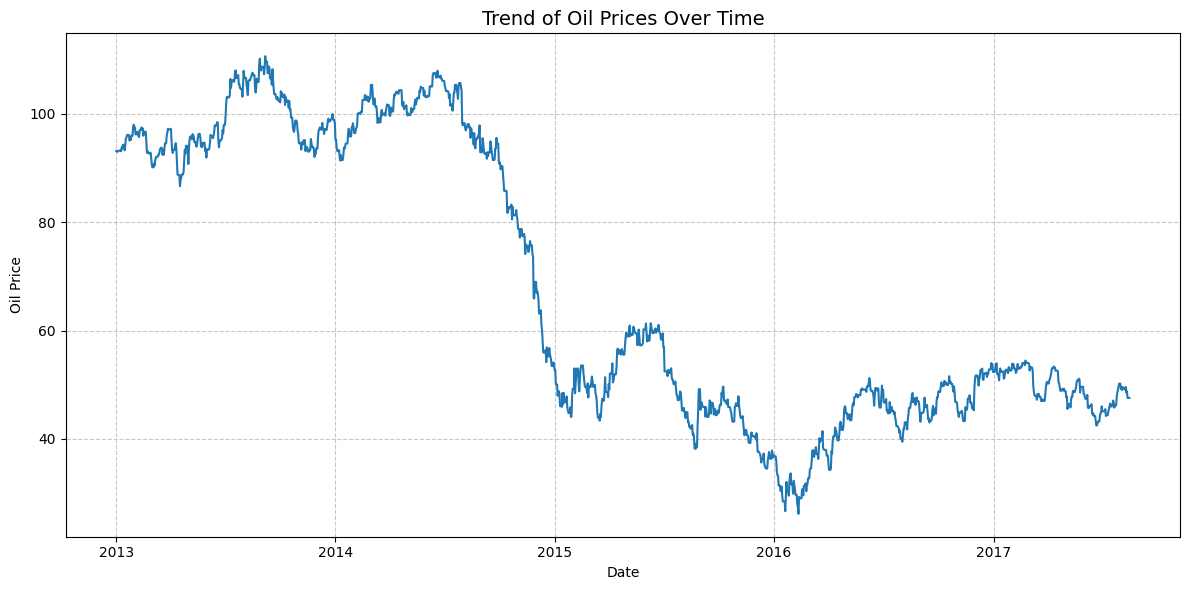

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(train['date'], train['dcoilwtico'])

ax.set_title('Trend of Oil Prices Over Time', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Oil Price')

ax.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
train.transactions = train.transactions.replace(np.nan,0)

In [ ]:
# Missing value handling for holiday and event columns in train data
train[['locale','locale_name', 'description']] = train[['locale','locale_name', 'description']].replace(np.nan,'')
train['holiday_type'] = train['holiday_type'].replace(np.nan,'Work Day')
train['transferred'] = train['transferred'].replace(np.nan,False)

In [ ]:
train.isna().sum()

,0
id,0
date,0
store_nbr,0
family,0
sales,0
onpromotion,0
city,0
state,0
store_type,0
cluster,0


## Feature Engineering

### 📆 1. Seasonality Patterns

These help the model understand time-based variation in demand:

In [ ]:
train['day'] = train['date'].dt.day
train['month'] = train['date'].dt.month
train['week'] = train['date'].dt.isocalendar().week.astype(int)
train['year'] = train['date'].dt.year
train['day_of_week'] = train['date'].dt.dayofweek
train['is_weekend'] = (train['day_of_week'] >= 5).astype('uint8')
train['quarter'] = train['date'].dt.quarter
train['season'] = train['month'].apply(lambda x: 0 if x in [2,3] else 1 if x in [4,5,6] else 2 if x in [7,8] else 3 if x in [9,10,11] else 4)

In [ ]:
train['Days_to_Thanksgiving'] = (pd.to_datetime(train["year"].astype(str)+"-11-24", format="%Y-%m-%d") - pd.to_datetime(train["date"], format="%Y-%m-%d")).dt.days.astype(int)
train['Days_to_Christmas'] = (pd.to_datetime(train["year"].astype(str)+"-12-24", format="%Y-%m-%d") - pd.to_datetime(train["date"], format="%Y-%m-%d")).dt.days.astype(int)

### 🌐 2. External Economic Indicators
These account for macro-level factors that influence demand:

- **oil_price**: Proxy for economic health/inflation, which affects consumer spending.
- **is_holiday**, **holiday_type**: Holidays and events often lead to demand spikes.

In [ ]:
train['is_holiday'] = (train['holiday_type'] != 'Work Day').astype('uint8')

In [ ]:
train['is_holiday'].value_counts()

,count
is_holiday,
0,2560734
1,493614


### 🏪 3. Internal Business Factors
These are directly influenced by the retailer’s operations and strategy:

- **onpromotion**: Indicates whether an item is under promotion, often driving short-term sales increases.

In [ ]:
train['onpromotion'] = train['onpromotion'].apply(lambda x: 1 if x != 0 else 0)

In [ ]:
train['onpromotion'].value_counts()

,count
onpromotion,
0,2428528
1,625820


#### To experiment with dynamic pricing strategies, we’ll need a few things in place:

#### A price assigned to each row of data

#### A revenue column calculated as price × sales

#### Later on, we’ll adjust prices to see how changes impact overall revenue

In [ ]:
train.family.unique()

array(['AUTOMOTIVE', 'CELEBRATION', 'BREAD/BAKERY', 'BOOKS', 'BEVERAGES',
       'BEAUTY', 'BABY CARE', 'SEAFOOD', 'SCHOOL AND OFFICE SUPPLIES',
       'PRODUCE', 'PREPARED FOODS', 'POULTRY', 'PLAYERS AND ELECTRONICS',
       'PET SUPPLIES', 'PERSONAL CARE', 'MEATS', 'MAGAZINES',
       'LIQUOR,WINE,BEER', 'LINGERIE', 'LAWN AND GARDEN', 'LADIESWEAR',
       'HOME CARE', 'HOME APPLIANCES', 'CLEANING', 'DAIRY', 'DELI',
       'EGGS', 'HOME AND KITCHEN II', 'HOME AND KITCHEN I', 'HARDWARE',
       'GROCERY II', 'GROCERY I', 'FROZEN FOODS'], dtype=object)

In [ ]:
family_price_mapping = {
    'AUTOMOTIVE': 100.0,
    'BABY CARE': 25.0,
    'BEAUTY': 18.0,
    'BEVERAGES': 8.0,
    'BOOKS': 12.0,
    'BREAD/BAKERY': 4.0,
    'CELEBRATION': 20.0,
    'CLEANING': 10.0,
    'DAIRY': 6.0,
    'DELI': 9.0,
    'EGGS': 3.5,
    'FROZEN FOODS': 7.0,
    'GROCERY I': 5.0,
    'GROCERY II': 4.5,
    'HARDWARE': 45.0,
    'HOME AND KITCHEN I': 35.0,
    'HOME AND KITCHEN II': 30.0,
    'HOME APPLIANCES': 150.0,
    'HOME CARE': 15.0,
    'LADIESWEAR': 28.0,
    'LAWN AND GARDEN': 40.0,
    'LINGERIE': 22.0,
    'LIQUOR,WINE,BEER': 18.0,
    'MAGAZINES': 5.0,
    'MEATS': 10.0,
    'PERSONAL CARE': 14.0,
    'PET SUPPLIES': 17.0,
    'PLAYERS AND ELECTRONICS': 200.0,
    'POULTRY': 8.0,
    'PREPARED FOODS': 9.0,
    'PRODUCE': 5.0,
    'SCHOOL AND OFFICE SUPPLIES': 10.0,
    'SEAFOOD': 20.0
}

train['base_price'] = train['family'].map(family_price_mapping)

# Simulate time-varying prices with ±10% random daily noise
np.random.seed(42)
train['daily_variation'] = np.random.uniform(0.9, 1.1, size=len(train))

train['price'] = (train['base_price'] * train['daily_variation']).round(2)
train['revenue'] = (train['price'] * train['sales']).round(2)

In [ ]:
train.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'store_type', 'cluster', 'dcoilwtico', 'transactions',
       'holiday_type', 'locale', 'locale_name', 'description', 'transferred',
       'day', 'month', 'week', 'year', 'day_of_week', 'is_weekend', 'quarter',
       'season', 'Days_to_Thanksgiving', 'Days_to_Christmas', 'is_holiday',
       'base_price', 'daily_variation', 'price', 'revenue'],
      dtype='object')

In [ ]:
train.isna().sum()

,0
id,0
date,0
store_nbr,0
family,0
sales,0
onpromotion,0
city,0
state,0
store_type,0
cluster,0


In [ ]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,...,is_weekend,quarter,season,Days_to_Thanksgiving,Days_to_Christmas,is_holiday,base_price,daily_variation,price,revenue
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,0,1,4,327,357,1,100.0,0.974908,97.49,0.0
1194,1194,2013-01-01,42,CELEBRATION,0.0,0,Cuenca,Azuay,D,2,...,0,1,4,327,357,1,20.0,1.090143,21.80,0.0
1193,1193,2013-01-01,42,BREAD/BAKERY,0.0,0,Cuenca,Azuay,D,2,...,0,1,4,327,357,1,4.0,1.046399,4.19,0.0
1192,1192,2013-01-01,42,BOOKS,0.0,0,Cuenca,Azuay,D,2,...,0,1,4,327,357,1,12.0,1.019732,12.24,0.0
1191,1191,2013-01-01,42,BEVERAGES,0.0,0,Cuenca,Azuay,D,2,...,0,1,4,327,357,1,8.0,0.931204,7.45,0.0


### Dropping Unneccessary Columns in The Train Dataset as it is not needed for our analysis

In [ ]:
columns_to_drop = ['date','id', 'locale', 'locale_name', 'description','transferred', 'state','base_price','daily_variation']
train = train.drop(columns=columns_to_drop)

In [ ]:
train.columns

Index(['store_nbr', 'family', 'sales', 'onpromotion', 'city', 'store_type',
       'cluster', 'dcoilwtico', 'transactions', 'holiday_type', 'day', 'month',
       'week', 'year', 'day_of_week', 'is_weekend', 'quarter', 'season',
       'Days_to_Thanksgiving', 'Days_to_Christmas', 'is_holiday', 'price',
       'revenue'],
      dtype='object')

In [ ]:
# Encode store_type and family
store_type_mapping = {stype: idx for idx, stype in enumerate(train['store_type'].unique())}
train['store_type_encoded'] = train['store_type'].map(store_type_mapping)

family_mapping = {family: idx for idx, family in enumerate(train['family'].unique())}
train['family_encoded'] = train['family'].map(family_mapping)

In [ ]:
print("Store Type Mapping:")
for stype, idx in store_type_mapping.items():
    print(f"{stype}: {idx}")

print("\nFamily Mapping:")
for family, idx in family_mapping.items():
    print(f"{family}: {idx}")


Store Type Mapping:
D: 0
E: 1
C: 2
A: 3
B: 4

Family Mapping:
AUTOMOTIVE: 0
CELEBRATION: 1
BREAD/BAKERY: 2
BOOKS: 3
BEVERAGES: 4
BEAUTY: 5
BABY CARE: 6
SEAFOOD: 7
SCHOOL AND OFFICE SUPPLIES: 8
PRODUCE: 9
PREPARED FOODS: 10
POULTRY: 11
PLAYERS AND ELECTRONICS: 12
PET SUPPLIES: 13
PERSONAL CARE: 14
MEATS: 15
MAGAZINES: 16
LIQUOR,WINE,BEER: 17
LINGERIE: 18
LAWN AND GARDEN: 19
LADIESWEAR: 20
HOME CARE: 21
HOME APPLIANCES: 22
CLEANING: 23
DAIRY: 24
DELI: 25
EGGS: 26
HOME AND KITCHEN II: 27
HOME AND KITCHEN I: 28
HARDWARE: 29
GROCERY II: 30
GROCERY I: 31
FROZEN FOODS: 32


In [ ]:
train.head()

,store_nbr,family,sales,onpromotion,city,store_type,cluster,dcoilwtico,transactions,holiday_type,...,is_weekend,quarter,season,Days_to_Thanksgiving,Days_to_Christmas,is_holiday,price,revenue,store_type_encoded,family_encoded
0,1,AUTOMOTIVE,0.0,0,Quito,D,13,93.14,0.0,Holiday,...,0,1,4,327,357,1,97.49,0.0,0,0
1194,42,CELEBRATION,0.0,0,Cuenca,D,2,93.14,0.0,Holiday,...,0,1,4,327,357,1,21.80,0.0,0,1
1193,42,BREAD/BAKERY,0.0,0,Cuenca,D,2,93.14,0.0,Holiday,...,0,1,4,327,357,1,4.19,0.0,0,2
1192,42,BOOKS,0.0,0,Cuenca,D,2,93.14,0.0,Holiday,...,0,1,4,327,357,1,12.24,0.0,0,3
1191,42,BEVERAGES,0.0,0,Cuenca,D,2,93.14,0.0,Holiday,...,0,1,4,327,357,1,7.45,0.0,0,4


# **Reinforcement Learning (Q-Learning)**

Reinforcement Learning (Q-Learning) for Dynamic Pricing
Why?

Learns from interaction: raises/lower prices based on demand feedback.

Adapts over time: learns what pricing works best in each situation.

Goal: Maximize revenue

State: Features like day of week, promo flag, oil price, etc.

Actions: Adjust price (↓ -5%, same, ↑ +5%)

Reward: Revenue resulting from the chosen price

#### Build the Q-Learning Environment
##### Define the Environment Columns
##### We'll use the following columns from your dataset as state features:

###### Feature	          ----->    Use
###### family	           -----> Demand segment
###### onpromotion	       -----> Sales boost signal
###### oil_price	       -----> Cost proxy
###### dayofweek	      -----> Temporal signal
###### is_weekend	      -----> Higher demand probability
###### store_type       ------> Adds additional context by capturing differences in store categories or formats

In [ ]:
actions = {
    0: -0.05,
    1: 0.00,
    2: +0.05
}


actions :

0 : Decrease price by 5%

1 : Keep price the same

2 : Increase price by 5%

In [ ]:
dynamic_price_df = train.copy()

In [ ]:
dynamic_price_df['log_sales'] = np.log1p(dynamic_price_df['sales'])

dynamic_price_df['log_revenue'] = np.log1p(dynamic_price_df['revenue'])

dynamic_price_df['log_price'] = np.log1p(dynamic_price_df['price'])

# Bin oil price
dynamic_price_df['oil_bin'] = pd.cut(dynamic_price_df['dcoilwtico'], bins=[0, 40, 60, 100], labels=[0, 1, 2])

# Drop rows with missing bins
dynamic_price_df = dynamic_price_df.dropna(subset=['oil_bin'])

# RL state
dynamic_price_df['state'] = list(zip(
    dynamic_price_df['day_of_week'],
    dynamic_price_df['onpromotion'],
    dynamic_price_df['is_weekend'],
    dynamic_price_df['oil_bin'].astype(int),
    dynamic_price_df['family_encoded'],
    dynamic_price_df['store_type_encoded']
))

class QLearningTable:
    def __init__(self, actions, learning_rate=0.01, reward_decay=0.95, e_greedy=0.8):
        self.actions = actions
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon = e_greedy
        self.q_table = {}

    def choose_action(self, observation):
        if observation not in self.q_table:
            self.q_table[observation] = {a: 0.0 for a in self.actions}

        state_action = self.q_table[observation]

        if np.random.uniform() > self.epsilon:
            # Exploration
            action = np.random.choice(self.actions)
        else:
            # Exploitation
            max_value = max(state_action.values())
            best_actions = [a for a, v in state_action.items() if v == max_value]
            action = np.random.choice(best_actions)

        return action

    def learn(self, s, a, r, s_):
        self.check_state_exist(s)
        self.check_state_exist(s_)

        q_predict = self.q_table[s][a]
        if s_ != 'terminal':
            q_target = r + self.gamma * max(self.q_table[s_].values())
        else:
            q_target = r
        self.q_table[s][a] += self.lr * (q_target - q_predict)

    def check_state_exist(self, state):
        if state not in self.q_table:
            self.q_table[state] = {a: 0.0 for a in self.actions}



### Q-Learning Setup

---

#### Data Preparation

- Applied **log transformation** to the following columns:
  - `sales`, `revenue`, `price`
  - Helps stabilize variance and improve learning efficiency.
  
- Created **oil price bins**:
  - `low` (0–40), `medium` (40–60), `high` (60–100)
  - Removed rows with missing bin values.

- Defined the **environment state** using the following features:
  - `day_of_week`
  - `onpromotion`
  - `is_weekend`
  - `oil_bin`
  - `family_encoded`
  - `store_type_encoded`

---

#### Q-Learning Agent (`QLearningTable` Class)

- **Initialization**
  - Sets learning parameters:
    - Learning rate (`alpha`)
    - Discount factor (`gamma`)
    - Exploration rate (`epsilon`)

- **Action Selection**
  - Chooses the best action (`argmax(Q)`) with probability `epsilon` (exploitation).
  - Otherwise, selects a random action (exploration).

- **Learning Rule**
  - Updates Q-values using the **Bellman Equation**:
    ```
    Q(s, a) ← Q(s, a) + α * [r + γ * max_a Q(s', a) - Q(s, a)]
    ```

- **State Management**
  - Adds new states to the Q-table if they’re not already present.

---

This forms the core of our reinforcement learning framework, enabling dynamic pricing based on environment signals.


In [ ]:
from tqdm import tqdm

def train_with_early_stopping(dynamic_price_df, num_episodes=200, sample_size=50000, patience=10, clip_reward=True, reward_clip_value=1000):
    actions = [0, 1, 2]
    RL = QLearningTable(actions=actions)

    episode_rewards = []
    episode_stds = []
    cumulative_rewards = []

    if len(dynamic_price_df) > sample_size:
        df = dynamic_price_df.sample(sample_size, random_state=42).reset_index(drop=True)
    else:
        df = dynamic_price_df.copy()

    print(f"Training on {len(df):,} rows for {num_episodes} episodes...")

    no_improvement_count = 0
    best_mean_reward = -np.inf

    for episode in tqdm(range(num_episodes), desc="Training"):
        total_rewards = []
        total_cumulative_reward = 0

        for i in range(len(df)):
            row = df.loc[i]
            current_price = row['log_price']
            base_sales = row['log_sales']
            base_revenue = row['log_revenue']
            state = tuple(row['state'])

            # RL chooses action
            action = RL.choose_action(str(state))

            # Apply action
            price_change = {0: -0.05, 1: 0.00, 2: 0.05}[action]
            new_price = current_price * (1 + price_change)
            new_sales = base_sales * (1 - 1.5 * price_change)
            new_sales = max(0, new_sales)
            new_revenue = new_price * np.expm1(new_sales)

            reward = new_revenue - base_revenue

            if clip_reward:
                reward = np.clip(reward, -reward_clip_value, reward_clip_value)

            total_rewards.append(reward)
            total_cumulative_reward += reward

            # Next state (or terminal)
            if i == len(df) - 1:
                next_state = 'terminal'
            else:
                next_state = tuple(df.loc[i + 1, 'state'])

            RL.learn(str(state), action, reward, str(next_state))

        mean_reward = np.mean(total_rewards)
        episode_rewards.append(mean_reward)
        episode_stds.append(np.std(total_rewards))
        cumulative_rewards.append(total_cumulative_reward)

        # Early stopping condition
        if mean_reward > best_mean_reward:
            best_mean_reward = mean_reward
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if no_improvement_count >= patience:
            print(f"Early stopping after {episode+1} episodes due to no improvement.")
            break

    with open('/content/drive/MyDrive/favorita-grocery-sales-forecasting/trained_model_RL_2.pkl', 'wb') as file:
        pickle.dump(RL.q_table, file)

    return episode_rewards, episode_stds, cumulative_rewards


def plot_rewards(episode_means):
    plt.figure(figsize=(10, 5))
    plt.plot(episode_means, label='Mean Reward per Episode', marker='o')
    window = 5
    if len(episode_means) >= window:
        moving_avg = np.convolve(episode_means, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(episode_means)), moving_avg, linestyle='--', color='red', label=f'{window}-Episode Moving Avg')
    plt.xlabel('Episode')
    plt.ylabel('Mean Reward')
    plt.title('Reward over Episodes')
    plt.legend()
    plt.grid(True)
    plt.show()

episode_means, episode_stds, cumulative_rewards = train_with_early_stopping(dynamic_price_df, num_episodes=200, sample_size=200000)


results_table = pd.DataFrame({
    'Episode': list(range(1, len(episode_means)+1)),
    'Mean Reward': episode_means,
    'Std Reward': episode_stds
})

Training on 200,000 rows for 200 episodes...


Training: 100%|██████████| 200/200 [5:00:14<00:00, 90.07s/it]


## Training the Q-Learning Agent with Early Stopping

---

### Training Function: `train_with_early_stopping(...)`

This function trains the Q-learning agent using a sampled subset of the dataset, with early stopping to prevent overfitting or wasted computation.

#### Key Parameters:
- `num_episodes`: Number of training iterations (default: 200)
- `sample_size`: Number of rows sampled from the dataset (default: 50,000)
- `patience`: Number of episodes to wait for improvement before stopping early
- `clip_reward`: Whether to clip rewards to avoid outliers
- `reward_clip_value`: The upper/lower bound for clipped reward (default: ±1000)

#### Training Logic:
- For each episode:
  - Iterate over sampled rows
  - Use the Q-agent to choose an action:
    - `0`: Decrease price by 5%
    - `1`: Keep price constant
    - `2`: Increase price by 5%
  - Simulate the effect on sales and revenue
  - Compute the reward: `new_revenue - base_revenue`
  - Optionally clip the reward to reduce noise
  - Update the Q-table using the Bellman equation
- Track:
  - Mean reward per episode
  - Standard deviation of rewards
  - Total cumulative reward

#### Early Stopping:
- If the mean reward doesn’t improve over `patience` consecutive episodes, training stops early.

#### Model Saving:
- The final Q-table is saved as a pickle file:


In [ ]:
sorted_results = results_table.sort_values(by='Episode').reset_index(drop=True)

batch_size = 10
num_batches = int(np.ceil(len(sorted_results) / batch_size))

for batch in range(num_batches):
    start = batch * batch_size
    end = start + batch_size
    print(f"\n=== Results {start+1} to {min(end, len(sorted_results))} ===")
    print(sorted_results.iloc[start:end])


=== Results 1 to 10 ===
   Episode  Mean Reward  Std Reward
0        1   150.678724  293.771286
1        2   150.785515  293.832594
2        3   150.761699  293.857346
3        4   150.799285  293.888776
4        5   150.644815  293.587184
5        6   150.686749  293.638052
6        7   150.738176  293.815391
7        8   150.718841  293.657595
8        9   150.817182  293.835164
9       10   150.771904  293.793592

=== Results 11 to 20 ===
    Episode  Mean Reward  Std Reward
10       11   150.698597  293.696366
11       12   150.754853  293.757373
12       13   150.824015  293.884599
13       14   150.885320  293.970004
14       15   150.636266  293.531989
15       16   150.664997  293.652343
16       17   150.776529  293.795413
17       18   150.804828  293.826128
18       19   150.919818  293.977153
19       20   151.087887  294.234184

=== Results 21 to 30 ===
    Episode  Mean Reward  Std Reward
20       21   151.063965  294.242359
21       22   151.543316  294.841447
22       

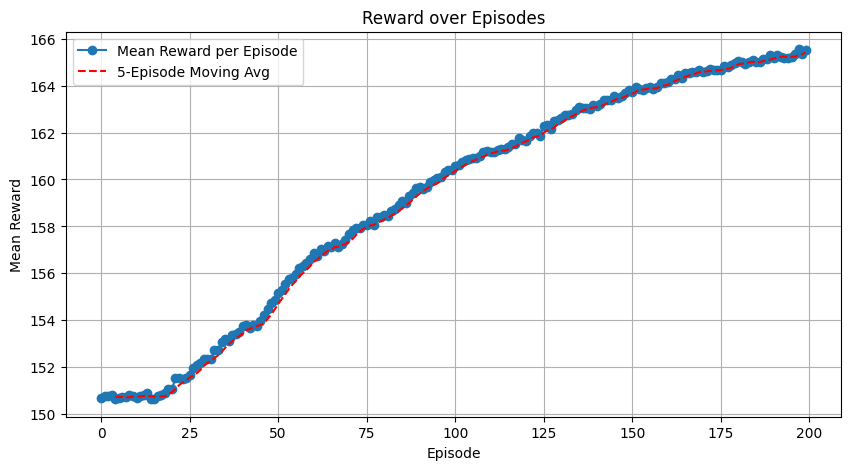

In [ ]:
plot_rewards(episode_means)

Agent Learned:
In some states, decreasing price increases total revenue.

In others, keeping price stable or even increasing it might reduce revenue.

The agent builds its own price strategy over time.

In [ ]:
import ast

def hamming_distance(t1, t2):
    return sum(a != b for a, b in zip(t1, t2))

def safe_literal_eval_tuple_keys(q_table):
    parsed_keys = []
    for k in q_table.keys():
        try:
            parsed = ast.literal_eval(k)
            if isinstance(parsed, tuple) and len(parsed) == 6:
                parsed_keys.append((parsed, k))
        except (ValueError, SyntaxError):
            continue
    return parsed_keys

def predict_price(date, onpromotion, oil_price, current_price, family_encoded, store_type_encoded):
    dt = pd.to_datetime(date)
    day_of_week = dt.weekday()
    is_weekend = int(day_of_week >= 5)

    oil_bin = pd.cut([oil_price], bins=[0, 40, 60, 100], labels=[0, 1, 2])[0]
    if pd.isnull(oil_bin):
        return "Oil price is out of expected range (0–100)."

    current_state = (day_of_week, int(onpromotion), is_weekend, int(oil_bin), int(family_encoded), int(store_type_encoded))
    state_str = str(current_state)

    # Retrieve Q-table values
    if state_str in q_table:
        state_action = q_table[state_str]
        used_state = state_str
    else:
        parsed_q_table_keys = safe_literal_eval_tuple_keys(q_table)
        if not parsed_q_table_keys:
            return "No valid states available in Q-table."

        closest_state = min(
            parsed_q_table_keys,
            key=lambda x: hamming_distance(current_state, x[0])
        )[1]
        state_action = q_table[closest_state]
        used_state = f"Fallback to {closest_state}"

    # Select best action
    max_value = max(state_action.values())
    best_actions = [a for a, v in state_action.items() if v == max_value]
    chosen_action = np.random.choice(best_actions)

    # Apply price adjustment
    price_change = {0: -0.05, 1: 0.0, 2: 0.05}[chosen_action]
    new_price = current_price * (1 + price_change)

    return {
        "recommended_action": chosen_action,
        "action_meaning": {0: "Decrease 5%", 1: "Keep", 2: "Increase 5%"}[chosen_action],
        "recommended_price": round(new_price, 2)
    }


## Price Recommendation Function

---

### Function: `predict_price(...)`

This function uses the trained **Q-learning model** to recommend a price adjustment based on the current environment (state). It either retrieves the exact state from the Q-table or finds the closest match using **Hamming distance** if the state is missing.

---

### Inputs:
- `date`: The date for which the price recommendation is requested.
- `onpromotion`: Whether the item is on promotion (`1` or `0`).
- `oil_price`: External cost signal used to bin the state.
- `current_price`: Current price of the item.
- `family_encoded`: Encoded family ID representing demand segment.
- `store_type_encoded`: Encoded store type ID.

---

### Step-by-step Breakdown:

1. **Date Features**
   - Extract `day_of_week` and `is_weekend` from the input date.

2. **Oil Price Binning**
   - Bin `oil_price` into one of three categories:
     - `0`: Low (0–40)
     - `1`: Medium (40–60)
     - `2`: High (60–100)
   - If the price is outside the expected range, the function returns an error message.

3. **State Construction**
   - Build a state tuple:  
     `(day_of_week, onpromotion, is_weekend, oil_bin, family_encoded, store_type_encoded)`

4. **Q-table Lookup**
   - If the state exists in the Q-table, use its action values.
   - If not:
     - Use `safe_literal_eval_tuple_keys()` to parse Q-table keys.
     - Apply `hamming_distance()` to find the closest state.
     - Use the closest state's action values as a fallback.

5. **Action Selection**
   - Choose the best action (the one with the highest Q-value).
   - If multiple actions have the same value, choose randomly among them.

6. **Apply Price Adjustment**
   - Based on the action:
     - `0`: Decrease price by 5%
     - `1`: Keep price unchanged
     - `2`: Increase price by 5%
   - Return the new recommended price.

---

### Helper Functions

#### `hamming_distance(t1, t2)`
- Computes the number of different elements between two tuples (used for state similarity).

#### `safe_literal_eval_tuple_keys(q_table)`
- Safely parses string keys in the Q-table into tuples.
- Filters for valid tuples of length 6 (matching state structure).

---

### Output
Returns a dictionary with:
{
    "recommended_action"
    "action_meaning"
    "recommended_price"
}

In [ ]:
with open('/content/drive/MyDrive/favorita-grocery-sales-forecasting/trained_model_RL_2.pkl', 'rb') as file:
    q_table = pickle.load(file)

result = predict_price(
    date="2025-10-30",
    onpromotion=0,
    oil_price=100,
    current_price=1000,
    family_encoded=1,
    store_type_encoded = 1
)

print(result)



{'recommended_action': np.int64(0), 'action_meaning': 'Decrease 5%', 'recommended_price': 950.0}
